# Model Pipeline

`roboflow` : 객체 탐지 -> `predict2crop()` : 이미지 크롭 -> `CLOVA_api()`: OCR_api -> 텍스트 추출

- packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import numpy as np
import platform
from PIL import ImageFont, ImageDraw, Image
from matplotlib import pyplot as plt
import requests
import base64
import uuid
import json
import time
import cv2
import requests
import platform
# from google.colab.patches import cv2_imshow
import numpy as np
import os
!pip install roboflow
from roboflow import Roboflow

## Modules

In [14]:
def CLOVA_api(secret_key, api_url, image : np.array):
    """
    Usage : CLOVA api 호출

    Parameters
    ----------
    secret_key : api key
    api_url : api_url
    image : 크롭된 image

    Returns
    -------

    response : api 호출 결과 (ex. 200,400,404, ...)

    """
    # Convert np.ndarray to bytes
    if image is not None:
        _, buffer = cv2.imencode('.jpg', image)
        file_data = buffer.tobytes()

    request_json = {
        'images': [
            {
                'format': 'jpg',
                'name': 'demo',
                'data': base64.b64encode(file_data).decode()
                #'url': image_url
            }
        ],
        'requestId': str(uuid.uuid4()),
        'version': 'V2',
        'timestamp': int(round(time.time() * 1000))
    }
    payload = json.dumps(request_json).encode('UTF-8')
    headers = {
      'X-OCR-SECRET': secret_key,
      'Content-Type': 'application/json'
    }
    response = requests.request("POST", api_url, headers=headers, data = payload)

    return response




def imageOCR(response, img : np.array):
    """
    Usage : api 적용 결과 (OCR 결과) 시각화

    Parameters
    ----------
    response : api 호출 결과
    img : 크롭된 이미지

    Returns
    -------
    temp : 추출된 text
    image : 크롭된 이미지 내 OCR 적용 결과

    """
    try : result = response.json()
    except :
        print(response, 'AttributeError: Responsed \'int\' object' )

    with open('result.json', 'w', encoding='utf-8') as make_file:
        json.dump(result, make_file, indent="\t", ensure_ascii=False)

    # Error 처리
    try : print(result['images'][0]['message'])
    except : return None, None

    # respone.json()에서 띄어쓰기 처리
    texts = connectWord(result)
    output = textPreprocessing(texts)

    # 이미지 시각화
    bBs = [b['boundingPoly'] for b in result['images'][0]['fields']]

    # bounding box 표시
    for box in bBs:
        vertices = np.array([(int(point['x']), int(point['y'])) for point in box['vertices']], np.int32)
        vertices = vertices.reshape((-1, 1, 2))
        img = cv2.polylines(img, [vertices], isClosed=True, color=(255, 0, 0), thickness=2)

    # 이미지 보여주기
    cv2_imshow(img) # only colab
    # print(text)

    return output, img


def textPreprocessing(input_str : str):
    import re

    print(input_str)
    # 특수 기호 처리
    pattern = re.compile(r'[@#$%^&*()_+{}\[\]:;<>.?\/|`~-]')
    result_str = pattern.sub('', input_str)
    print(result_str)
    return result_str



def connectWord(ocr_json):
    """
    Usage : OCR 결과 내 띄어쓰기 처리

    Parameters
    ----------
    ocr_json : api 호출 결과

    Returns -> str
    -------
    detected_texts : 최종 결과

    """
    detected_texts = ''

    # 필드 정보 추출
    fields = ocr_json['images'][0].get('fields', [])

    # 각 필드에 대해 y좌표 계산
    word_list = []
    for field in fields:
        bounding_poly = field.get('boundingPoly')
        infer_text = field.get('inferText')

        if bounding_poly and infer_text:
            vertices = bounding_poly['vertices']
            print(vertices)
            left_y_coord = vertices[0]['y']  # 첫 번째 꼭짓점의 y좌표를 사용
            right_y_coord = vertices[1]['y']
            word = infer_text
            word_list.append({'word': word, 'left_y': left_y_coord, 'right_y':right_y_coord})

    # y좌표가 유사한 단어를 그룹화
    grouped_words = []
    if word_list:  # word_list가 비어있지 않은 경우에만 처리
        current_group = [word_list[0]]

        for i in range(1, len(word_list)):
            if abs(word_list[i]['left_y'] - word_list[i-1]['right_y']) < 10:
                current_group.append(word_list[i])
            else:
                grouped_words.append(current_group)
                current_group = [word_list[i]]

        if current_group:
            grouped_words.append(current_group)

    for group in grouped_words:
        # 그룹 내의 단어들을 하나의 문자열로 합침
        group_text = ' '.join([word_info['word'] for word_info in group])
        print(group, group_text)
        # 문자열이 정수로만 이루어져 있지 않은 경우에만 출력
        if not group_text.isdigit():
            detected_texts += group_text
            detected_texts += '\t'

    return detected_texts



def modelPredict(model, input_Data):
    try : predictions_data = model.predict(input_Data, confidence=50, overlap=50).json()
    except :
        print('Predict Error')
        return None
    # image_path = predictions_data['predictions'][0]['image_path']  # Assuming all predictions have the same image path

    return predictions_data



def predict2crop(model, folder_path, image_file, resize = 256):
    """
    Usage : 객체 탐지 및 원본 및 크롭 이미지 return

    Parameters
    ----------
    model : Object Detection Model
    folder_path : 데이터 폴더 경로
    image_file : 데이터 파일 경로

    Returns : (original_image, cropped_image)
    -------
    type : tuple
    original_image : 원본 이미지
    cropped_image : 크롭된 이미지

    """
    image_path = folder_path + image_file
    img_size = resize # img_size * img_size

    org_img = cv2.imread(image_path)
    if org_img is None:
        print(f"Error: Unable to read the image file {image_path}")
        return None, None

    rsz_img = cv2.resize(org_img, (img_size, img_size), interpolation= cv2.INTER_AREA)
    adc_img = auto_adjust_contrast(rsz_img)


    predictions_data = modelPredict(model, input_Data = adc_img) # resize된 img속에서 찾은 bbox 좌표

    print('Detected Obj : ', len(predictions_data['predictions']))

    if predictions_data is None :
        print('Detect Nothing. It\'s Too Close')
        return org_img, org_img

    if len(predictions_data['predictions']) > 1:
        print('! Error : Multiple detection Error. Take more closer')
        return None, None

    orgBBcoor = predBBcoor(org_img, predictions_data)
    cropped_img = imgCrop(org_img, orgBBcoor) #원본이미지에서 crop

    return org_img, cropped_img



def imgCrop(img, bbCoor):
    """
    Usage : resize된 이미지에서의 바운딩 박스 좌표를 원본 이미지의 바운딩 박스 좌표로 변환

    Parameters
    ----------
    img : 원본 이미지(no resize)
    bbCoor : (x, y, width, height) -> 원본 이미지에서의 bbox 좌표

    Returns : np.array
    -------
    cropped_img

    """
    if None in bbCoor : return img

    x, y, width, height = bbCoor # real coordinate

    half_w, half_h = round(width/2), round(height/2)

    cropped_img = img[abs(y-half_h) : y+half_h, abs(x-half_w ): x+half_w] # img crop

    # # 결과 시각화
    # cv2.rectangle(img, (x - half_w, y - half_h), (x + half_w, y + half_h), (0, 255, 0), 2)
    # print('\n Original')
    # cv2_imshow(img) # only colab
    # print('\n Cropped')
    # cv2_imshow(cropped_img) # only colab

    return cropped_img



def predBBcoor(org_img : np.array, pred_data : list, resize=256):
    """
    Usage : resize된 이미지에서의 바운딩 박스 좌표를 원본 이미지의 바운딩 박스 좌표로 변환

    Parameters
    ----------
    org_img : 원본 이미지(no resize)
    pred_data : list

    Returns : tuple
    -------
    x, y, width, height

    """
    try : prediction = pred_data['predictions'][0] # dict
    except : return None, None, None, None # 탐지 되지 않을 시

    # resized bbox coordinate
    rx, ry, rwidth, rheight = int(prediction['x']), int(prediction['y']), int(prediction['width']), int(prediction['height'])
    half_w, half_h = round(rwidth/2), round(rheight/2)

    # real h, w
    h, w, _ = org_img.shape
    # real bbox coordinate
    x, y, width, height = round((w*rx)/resize), round((h*ry)/resize), round((rwidth*w)/256), round((rheight*h)/256)

    return x, y, width, height



# preprocessing : auto_adjust_contrast
def auto_adjust_contrast(image : np.array):
    # Flatten the image to 1D array
    try : flat_image = image.flatten()
    except : return None

    # Compute the histogram
    histogram, bins = np.histogram(flat_image, bins=256, range=(0, 256))

    # Compute the cumulative distribution function (CDF)
    cdf = histogram.cumsum()

    # Normalize the CDF
    cdf_normalized = cdf / cdf.max()

    # Perform histogram equalization
    equalized_image = np.interp(flat_image, bins[:-1], cdf_normalized * 255).reshape(image.shape)

    return equalized_image.astype(np.uint8) # np.array

- model load

In [15]:
rf = Roboflow(api_key="eyKD4VJQ4nRqtosRytMg")
project = rf.workspace().project("price-tag-dxlmv")
model = project.version(15).model

model

loading Roboflow workspace...
loading Roboflow project...


In [21]:
# 데이터가 존재하는 폴더 경로
image_folder = '../'
files = os.listdir(image_folder)

# 데이터 폴더 내 이미지 파일들만 저장
image_files = [file for file in files] # 데이터 접근 : 다중 파일로 테스트 시, 파일 순회

##### input data 입력 #####
input_img = 'M09.JPG'

In [22]:
# 단일 이미지 넣을 시
if input_img:
# for image in image_files: # 다량의 이미지 테스트 용
    original_img, cropped_img = predict2crop(model, folder_path = image_folder ,image_file = input_img)
    # show_result(original_img, cropped_img, folder_path = image_folder ,image_file = image)


Predict Error


TypeError: 'NoneType' object is not subscriptable

SUCCESS
[{'x': 65.0, 'y': 6.0}, {'x': 113.0, 'y': 4.0}, {'x': 114.0, 'y': 23.0}, {'x': 66.0, 'y': 26.0}]
[{'x': 174.0, 'y': 3.0}, {'x': 183.0, 'y': 3.0}, {'x': 183.0, 'y': 14.0}, {'x': 174.0, 'y': 14.0}]
[{'x': 38.0, 'y': 24.0}, {'x': 84.0, 'y': 21.0}, {'x': 85.0, 'y': 40.0}, {'x': 39.0, 'y': 43.0}]
[{'x': 98.0, 'y': 19.0}, {'x': 144.0, 'y': 16.0}, {'x': 146.0, 'y': 37.0}, {'x': 99.0, 'y': 40.0}]
[{'x': 5.0, 'y': 46.0}, {'x': 37.0, 'y': 46.0}, {'x': 37.0, 'y': 54.0}, {'x': 5.0, 'y': 54.0}]
[{'x': 114.0, 'y': 38.0}, {'x': 143.0, 'y': 38.0}, {'x': 143.0, 'y': 50.0}, {'x': 114.0, 'y': 50.0}]
[{'x': 156.0, 'y': 36.0}, {'x': 183.0, 'y': 33.0}, {'x': 184.0, 'y': 44.0}, {'x': 157.0, 'y': 47.0}]
[{'x': 9.0, 'y': 72.0}, {'x': 130.0, 'y': 65.0}, {'x': 130.0, 'y': 71.0}, {'x': 10.0, 'y': 78.0}]
[{'x': 46.0, 'y': 79.0}, {'x': 83.0, 'y': 77.0}, {'x': 84.0, 'y': 81.0}, {'x': 46.0, 'y': 83.0}]
[{'x': 84.0, 'y': 77.0}, {'x': 97.0, 'y': 77.0}, {'x': 98.0, 'y': 80.0}, {'x': 84.0, 'y': 81.0}]
[{'x': 147.

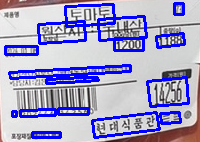

In [14]:
# OCR api
secret_key = "Y0l6ZHF1Um9CSWp3aHpJU3JDeFdpUGp1cG16T3hFQkg="
api_url = 'https://p0fsnflvaw.apigw.ntruss.com/custom/v1/27259/8a921c4c7d4e552c974b102e64c6227f3a2995ca938c066ddeb1442d6bf4b67c/general'


response = CLOVA_api(secret_key ,api_url ,image = cropped_img)
texts, img = imageOCR(response, img = cropped_img)

## Text preprocessing

In [47]:
' '.join(texts)

'토 마 토   7 3 \t 원 산 지   구 내 산 \t 2 0 2 4 0 1 0 6   1 2 0 0   1 1 8 8 \t J I N U U P H U N N S \t 2 0 1 1 6 1 7 9   1 0 M   1 4 2 5 6 \t 0   5 6 5 4 4   3 2 3 5 6 \t 현 대 식 품 관   1 3 \t \t'

In [ ]:
texts.split('\t')

['이 제품은 어디서 만들어졌을까요?',
 '리브니트 햇',
 'Rib-knit Hat',
 'W',
 '₩14,900',
 'HM.COM에서 자세히',
 '받아보시로',
 '']